In [94]:
# Import Dependencies
import pandas as pd
import numpy as np
import requests
from requests.exceptions import ConnectionError
from bs4 import BeautifulSoup
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [95]:
def get_team_stats_data(year: int) -> pd.DataFrame:
    # Pause for 3.5 seconds to avoid getting blocked (20 requests/minute limit)
    time.sleep(3.5)

    # Set the URL for season standings page
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}.html'

    # Get the HTML content of the page
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Get Columns to Use for each table
    columns_params = {
        'rate_stats': ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
        'advanced_stats': ['Team', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'Team eFG%', 'Team TOV%', 'Team ORB%', 'Team FT/FGA', 'Opponent eFG%', 'Opponent TOV%', 'Opponent DRB%', 'Opponent FT/FGA', 'Arena', 'Attend.', 'Attend./G'],
        'team_shooting_stats': ['Team', 'G', 'MP', 'FG%', 'Dist.', '%FGA 2P', '%FGA 0-3', '%FGA 3-10', '%FGA 10-16', '%FGA 16-3P', '%FGA 3P', '2P%', '0-3%', '3-10%', '10-16%', '16-3P%', '3P%', '2P Assisted %', '3P Assisted %', '%FGA Dunks', 'MD% Dunks', '%FGA Layup', 'MD% Layups', '%3PA Corner', '3P% Corner', 'Heaves Att.', 'Heaves Made'],
        'opponent_shooting_stats': ['Team', 'G', 'MP', 'FG%', 'Dist.', '%FGA 2P', '%FGA 0-3', '%FGA 3-10', '%FGA 10-16', '%FGA 16-3P', '%FGA 3P', '2P%', '0-3%', '3-10%', '10-16%', '16-3P%', '3P%', '2P Assisted %', '3P Assisted %', '%FGA Dunks', 'MD% Dunks', '%FGA Layup', 'MD% Layups', '%3PA Corner', '3P% Corner'],
        'team_shooting_stats_pre_2002': ['Team', 'G', 'MP', 'FG%', 'Dist.', '%FGA 2P', '%FGA 0-3', '%FGA 3-10', '%FGA 10-16', '%FGA 16-3P', '%FGA 3P', '2P%', '0-3%', '3-10%', '10-16%', '16-3P%', '3P%', '2P Assisted %', '3P Assisted %', '%FGA Dunks', 'MD% Dunks', '%3PA Corner', '3P% Corner', 'Heaves Att.', 'Heaves Made'],
        'opponent_shooting_stats_pre_2002': ['Team', 'G', 'MP', 'FG%', 'Dist.', '%FGA 2P', '%FGA 0-3', '%FGA 3-10', '%FGA 10-16', '%FGA 16-3P', '%FGA 3P', '2P%', '0-3%', '3-10%', '10-16%', '16-3P%', '3P%', '2P Assisted %', '3P Assisted %', '%FGA Dunks', 'MD% Dunks', '%3PA Corner', '3P% Corner']
    }

    # Get Standings Data & Combine dataframes & Clean the Team name column
    eastern_conference_standings_df = get_standings_data(soup, year, 'Eastern')
    western_conference_standings_df = get_standings_data(soup, year, 'Western')
    league_standings_df = pd.concat([eastern_conference_standings_df, western_conference_standings_df], ignore_index=True)
    league_standings_df = league_standings_df.sort_values(by='W/L%', ascending=False).reset_index(drop=True)
    
    # Get Team & Opponent Stats Data (Rate, Shooting, and Advanced Stats)
    team_rate_stats_df = get_team_stats(soup, year, 'team', 'per_poss-team', 'rate', columns_params['rate_stats'])
    team_advanced_stats_df = get_team_stats(soup, year, 'team', 'advanced-team', 'advanced', columns_params['advanced_stats'])
    opponent_rate_stats_df = get_team_stats(soup, year, 'opponent', 'per_poss-opponent', 'rate', columns_params['rate_stats'])
    if year >= 1997:
        if year < 2002:
            team_shooting_stats_df = get_team_stats(soup, year, 'team', 'shooting-team', 'shooting', columns_params['team_shooting_stats_pre_2002'])
            opponent_shooting_stats_df = get_team_stats(soup, year, 'opponent', 'shooting-opponent', 'shooting', columns_params['opponent_shooting_stats_pre_2002'])
        else:
            team_shooting_stats_df = get_team_stats(soup, year, 'team', 'shooting-team', 'shooting', columns_params['team_shooting_stats'])
            opponent_shooting_stats_df = get_team_stats(soup, year, 'opponent', 'shooting-opponent', 'shooting', columns_params['opponent_shooting_stats'])

    # Drop unnecessary columns from the dataframes
    team_advanced_stats_df = team_advanced_stats_df.drop(columns=['W', 'L', 'SRS'])
    opponent_rate_stats_df = opponent_rate_stats_df.drop(columns=['G', 'MP', 'Team/Opponent'])
    if year >= 1997:
        team_shooting_stats_df = team_shooting_stats_df.drop(columns=['G', 'MP', 'FG%', 'Team/Opponent'])
        opponent_shooting_stats_df = opponent_shooting_stats_df.drop(columns=['G', 'MP', 'FG%', 'Team/Opponent'])

    # Clean the Team name column for each dataframe
    if year >= 1997:
        league_standings_df, team_rate_stats_df, team_shooting_stats_df, team_advanced_stats_df, opponent_rate_stats_df, opponent_shooting_stats_df = clean_team_name_column([league_standings_df, team_rate_stats_df, team_shooting_stats_df, team_advanced_stats_df, opponent_rate_stats_df, opponent_shooting_stats_df])
    else:
        league_standings_df, team_rate_stats_df, team_advanced_stats_df, opponent_rate_stats_df = clean_team_name_column([league_standings_df, team_rate_stats_df, team_advanced_stats_df, opponent_rate_stats_df])
    
    # Add custom suffixes to all column names that would otherwise be duplicated
    if year >= 1997:
        team_rate_stats_df, team_shooting_stats_df, team_advanced_stats_df, opponent_rate_stats_df, opponent_shooting_stats_df = add_suffix([team_rate_stats_df, team_shooting_stats_df, team_advanced_stats_df, opponent_rate_stats_df, opponent_shooting_stats_df], ['_Per100_Team', '_Shooting', '_Advanced', '_Per100_Opponent', '_Shooting_Opponent'])
    else:
        team_rate_stats_df, team_advanced_stats_df, opponent_rate_stats_df = add_suffix([team_rate_stats_df, team_advanced_stats_df, opponent_rate_stats_df], ['_Per100_Team', '_Advanced', '_Per100_Opponent'])

    # Merge the dataframes
    df = pd.merge(league_standings_df, team_rate_stats_df, on=['Team', 'Year'])
    df = pd.merge(df, team_advanced_stats_df, on=['Team', 'Year'])
    df = pd.merge(df, opponent_rate_stats_df, on=['Team', 'Year'])
    if year >= 1997:
        df = pd.merge(df, team_shooting_stats_df, on=['Team', 'Year'])
        df = pd.merge(df, opponent_shooting_stats_df, on=['Team', 'Year'])
    
    # Get the playoff odds data
    odds_df = get_odds_data(year - 1, year)

    # Merge the odds data with the main dataframe
    df = pd.merge(df, odds_df, on='Team', how='left')

    return df

In [96]:
def get_game_logs_data(year: int, team_abbreviations: dict) -> pd.DataFrame:
    inverted_team_abbreviations = {v: k for k, v in team_abbreviations.items()}
    df_regular_season_combined = pd.DataFrame()
    df_playoffs_combined = pd.DataFrame()
    years_without_start_time_columns = ['G', 'Date', 'Box Score Link', 'Home/Road', 'Opponent', 'Result', 'OT', 'Tm', 'Opp', 'W', 'L', 'Streak',' Attend.', 'LOG', 'Notes']
    years_with_start_time_columns = ['G', 'Date', 'Start (ET)', 'Box Score Link', 'Home/Road', 'Opponent', 'Result', 'OT', 'Tm', 'Opp', 'W', 'L', 'Streak',' Attend.', 'LOG', 'Notes']

    for abbreviation in team_abbreviations.values():
        # Pause for 3.5 seconds to avoid getting blocked (20 requests/minute limit)
        time.sleep(3.5)

        print(f'Getting game logs for {abbreviation} in {year}')

        # Set the URL for the season game logs page
        url = f'https://www.basketball-reference.com/teams/{abbreviation}/{year}_games.html'

        # Get the HTML content of the page
        response = requests.get(url)
        if response.status_code == 404:
            print(f'Page not found for {abbreviation} in {year}. Skipping...')
            continue
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the table with the game logs data
        table = soup.find('table', {'id': 'games'})
        rows = table.find_all('tr')
        data = []

        # Extract the data from the table
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            data.append(cols)

        if len(data[1]) == 15:
            df_regular_season = pd.DataFrame(data, columns=years_without_start_time_columns)
        else:
            df_regular_season = pd.DataFrame(data, columns=years_with_start_time_columns)
        df_regular_season = df_regular_season.dropna(subset=['G'])

        # Add the Team/Year to the dataframe
        df_regular_season['Team'] = inverted_team_abbreviations[abbreviation]
        df_regular_season['Year'] = year

        # Find the table with the playoff game logs data (if it exists)
        table = soup.find('table', {'id': 'games_playoffs'})
        if table is not None:
            rows = table.find_all('tr')
            data = []

            # Extract the data from the table
            for row in rows:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                data.append(cols)

            if len(data[1]) == 15:
                df_playoffs = pd.DataFrame(data, columns=years_without_start_time_columns)
            else:
                df_playoffs = pd.DataFrame(data, columns=years_with_start_time_columns)
            df_playoffs = df_playoffs.dropna(subset=['G'])

            # Add the Team/Year to the dataframe
            df_playoffs['Team'] = inverted_team_abbreviations[abbreviation]
            df_playoffs['Year'] = year

            # Combine the dataframes for each team
            df_regular_season_combined = pd.concat([df_regular_season_combined, df_regular_season], ignore_index=True)
            df_playoffs_combined = pd.concat([df_playoffs_combined, df_playoffs], ignore_index=True)

    return df_regular_season_combined, df_playoffs_combined

In [97]:
def get_standings_data(soup: BeautifulSoup, year: int, conference: str) -> pd.DataFrame:
    # Find the standings table for the appropriate conference
    table_id = 'divs_standings_E' if conference == 'Eastern' else 'divs_standings_W'
    table = soup.find('table', {'id': table_id})
    rows = table.find_all('tr')
    data = []

    # Extract the data from the table
    for row in rows:
        team = row.find('th').text.strip()
        if 'Division' not in team and 'Conference' not in team:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            data.append([team] + cols)
    df = pd.DataFrame(data, columns=['Team', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'])
    df['Year'] = year
    df['Conference'] = 'Eastern' if conference == 'Eastern' else 'Western'
    df['Made Playoffs'] = df['Team'].apply(lambda x: 1 if '*' in x else 0)
    
    return df

In [98]:
def get_team_stats(soup: BeautifulSoup, year: int, team_or_opponent: str, table_id: str, table_type: str, columns: list) -> pd.DataFrame:
    # Find the appropriate table
    table = soup.find('table', {'id': table_id})
    rows = table.find_all('tr')
    data = []

    # Extract the data from the table
    for row in rows:
        rank = row.find('th').text.strip()
        if rank == 'Rk' or rank == '':
            continue
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele.text.strip() != '']
        data.append(cols)
    df = pd.DataFrame(data, columns=columns)
    df['Year'] = year
    if table_type != 'advanced':
        df['Team/Opponent'] = 'Team' if team_or_opponent == 'team' else 'Opponent'
    
    return df

In [99]:
def get_odds_data_html(url, retries=3, backoff_factor=0.5):
    for attempt in range(retries):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raises an HTTPError if the response status code is 4XX or 5XX
            return response
        except ConnectionError as e:
            print(f"Connection failed: {e}. Retrying...")
            time.sleep(backoff_factor * (2 ** attempt))
        except requests.exceptions.HTTPError as e:
            print(f"HTTP Error: {e}")
            break
    return None

In [100]:
def get_odds_data(start_year: int, end_year: int) -> pd.DataFrame:
    url = f'https://www.sportsoddshistory.com/nba-main/?y={start_year}-{end_year}&sa=nba&a=finals&o=r1'

    # Get the HTML content of the page
    response = get_odds_data_html(url)
    if response:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the table with the odds data
        table = soup.find('table', {'class': 'soh1'})

        # Extract the data from the table
        data = []

        # Find the index of the "Round 1" column
        headers = table.find_all('th')
        round_1_index = None
        counter = 0
        for i, header in enumerate(headers):
            counter += 1
            if '...' in header.text:
                counter -= 1
            if 'Round 1' in header.text:
                round_1_index = counter - len([th for th in headers[:i] if th.has_attr('rowspan')])  # Adjust for rowspan
                break

        # Add the data to the list if the column was found
        if round_1_index is not None:
            for row in table.find_all('tbody')[0].find_all('tr'):
                cols = row.find_all('td')
                team_name = cols[0].text.strip()
                round_1_data = cols[round_1_index].text.strip()
                data.append((team_name, round_1_data))
        else:
            print("Pre-Playoff odds not found.")

        # Create a dataframe from the data
        df = pd.DataFrame(data, columns=['Team', 'Odds'])

        return df

In [101]:
def add_suffix(dfs: list[pd.DataFrame], suffix: list[str]) -> list[pd.DataFrame]:
    current_index = 0

    for df in dfs:
        for column in df.columns:
            if column not in ['Team', 'Year', 'G', 'MP', 'Team/Opponent']:
                dfs[current_index] = dfs[current_index].rename(columns={column: column + suffix[current_index]})
        current_index += 1

    return dfs

In [102]:
def clean_team_name_column(dfs: list[pd.DataFrame]) -> list[pd.DataFrame]:
    for df in dfs:
        df['Team'] = (df['Team'].str.replace(r'\(\d+\)', '', regex=True)
                                .str.replace('(', '')
                                .str.replace(')', '')
                                .str.replace('*', '')
                                .str.rstrip())
    return dfs

In [103]:
def fill_in_custom_feature_columns(df: pd.DataFrame, df_game_log_regular_season: pd.DataFrame, df_game_log_playoffs: pd.DataFrame, year: int, start_year: int) -> pd.DataFrame:
    if 'Record vs .600+ Teams' not in df.columns:
        df['Record vs .600+ Teams'] = 0.0
    if 'Number of Playoff Wins (Last Year)' not in df.columns:
        df['Number of Playoff Wins (Last Year)'] = 0
        df['Champion Share (Last Year)'] = 0.0

    # Ensure numerical columns hold numeric values
    df['W/L%'] = pd.to_numeric(df['W/L%'], errors='coerce')
    df_game_log_regular_season['Tm'] = pd.to_numeric(df_game_log_regular_season['Tm'], errors='coerce')
    df_game_log_regular_season['Opp'] = pd.to_numeric(df_game_log_regular_season['Opp'], errors='coerce')

    # Calculate the record vs .600+ teams (in the regular season)
    teams_600_plus = df[(df['W/L%'] >= 0.600) & (df['Year'] == year)]['Team'].values
    for team in df['Team'].unique():
        # Filter game logs for current team & year against .600+ teams
        team_games_vs_600_plus = df_game_log_regular_season[(df_game_log_regular_season['Team'] == team) & 
                                                            (df_game_log_regular_season['Opponent'].isin(teams_600_plus)) & 
                                                            (df_game_log_regular_season['Year'] == year)]

        # Calculate win rate
        if not team_games_vs_600_plus.empty:
            wins = team_games_vs_600_plus['Result'].value_counts().get('W', 0)
            total_games = len(team_games_vs_600_plus)
            win_rate = wins / total_games if total_games > 0 else 0.0
        else:
            win_rate = 0.0
        
        # Assign win rate to the team in df
        df.loc[(df['Team'] == team) & (df['Year'] == year), 'Record vs .600+ Teams'] = win_rate
    
    # Calculate Record in Clutch Games (in the regular season)
    df_game_log_regular_season['Is Clutch'] = abs(df_game_log_regular_season['Tm'] - df_game_log_regular_season['Opp']) <= 5
    df_game_log_regular_season['Clutch Win'] = (df_game_log_regular_season['Is Clutch']) & (df_game_log_regular_season['Tm'] > df_game_log_regular_season['Opp'])

    # Create copies of Year/Team columns to avoid deprecated groupby behavior
    df['Year Copy'] = df['Year']
    df['Team Copy'] = df['Team']
    df_game_log_regular_season['Year Copy'] = df_game_log_regular_season['Year']
    df_game_log_regular_season['Team Copy'] = df_game_log_regular_season['Team']
    clutch_win_rates = df_game_log_regular_season.groupby(['Team Copy', 'Year Copy']).apply(lambda x: x['Clutch Win'].sum() / x['Is Clutch'].sum() if x['Is Clutch'].sum() > 0 else 0.0, include_groups=False).reset_index(name='Record in Clutch Games')
    df = df.merge(clutch_win_rates, on=['Team Copy', 'Year Copy'], how='left', suffixes=('', '_current'))
    
    # Handle Duplicate Columns (if they exist)
    if 'Record in Clutch Games_current' in df.columns:
        df['Record in Clutch Games'] = df.apply(lambda row: row['Record in Clutch Games_current'] if pd.notnull(row['Record in Clutch Games_current']) else row['Record in Clutch Games'], axis=1)
    
    # Drop unnecessary columns
    df_game_log_regular_season.drop(columns=['Is Clutch', 'Clutch Win'], inplace=True)
    df.drop(columns=['Year Copy', 'Team Copy'], inplace=True)
    if 'Record in Clutch Games_current' in df.columns:
        df.drop(columns=['Record in Clutch Games_current'], inplace=True)
    
    
    # Calculate Number of Playoff Wins in the previous year
    if year > start_year:
        for team in df['Team'].unique():
            previous_year_df = df_game_log_playoffs[(df_game_log_playoffs['Year'] == year - 1) & (df_game_log_playoffs['Team'] == team)]
            if not previous_year_df.empty:
                playoff_wins = previous_year_df['Result'].value_counts().get('W', 0)
            else:
                playoff_wins = 0

            # Calculate Champion Share
            playoff_wins_required = 0
            if year - 1 > 2002: # 2003 onwards had 16 playoff wins required
                playoff_wins_required = 16
            elif year - 1 > 1983: # 1984 had 15 playoff wins required
                playoff_wins_required = 15
            else:
                playoff_wins_required = 12 # Only 12 playoff wins required since 1980
            champion_share = playoff_wins / playoff_wins_required
            df.loc[(df['Team'] == team) & (df['Year'] == year), 'Number of Playoff Wins (Last Year)'] = playoff_wins
            df.loc[(df['Team'] == team) & (df['Year'] == year), 'Champion Share (Last Year)'] = champion_share

    return df

In [104]:
def scrape_and_save_data(df: pd.DataFrame, start_year: int, end_year: int) -> pd.DataFrame:
    team_info = {
    "Atlanta Hawks": {"abbreviation": "ATL", "start_year": 1980, "end_year": "Current"},
    "Boston Celtics": {"abbreviation": "BOS", "start_year": 1980, "end_year": "Current"},
    "Brooklyn Nets": {"abbreviation": "BRK", "start_year": 2013, "end_year": "Current"},
    "Charlotte Bobcats": {"abbreviation": "CHA", "start_year": 2005, "end_year": 2014},
    "Charlotte Hornets": {"abbreviation": "CHH", "start_year": 1989, "end_year": 2002}, # Returns to CHA in 2015 with abbreviation CHO
    "Chicago Bulls": {"abbreviation": "CHI", "start_year": 1980, "end_year": "Current"},
    "Cleveland Cavaliers": {"abbreviation": "CLE", "start_year": 1980, "end_year": "Current"},
    "Dallas Mavericks": {"abbreviation": "DAL", "start_year": 1981, "end_year": "Current"},
    "Denver Nuggets": {"abbreviation": "DEN", "start_year": 1980, "end_year": "Current"},
    "Detroit Pistons": {"abbreviation": "DET", "start_year": 1980, "end_year": "Current"},
    "Golden State Warriors": {"abbreviation": "GSW", "start_year": 1980, "end_year": "Current"},
    "Houston Rockets": {"abbreviation": "HOU", "start_year": 1980, "end_year": "Current"},
    "Indiana Pacers": {"abbreviation": "IND", "start_year": 1980, "end_year": "Current"},
    "Kansas City Kings": {"abbreviation": "KCK", "start_year": 1980, "end_year": 1985},
    "Los Angeles Clippers": {"abbreviation": "LAC", "start_year": 1985, "end_year": "Current"},
    "Los Angeles Lakers": {"abbreviation": "LAL", "start_year": 1980, "end_year": "Current"},
    "Memphis Grizzlies": {"abbreviation": "MEM", "start_year": 2002, "end_year": "Current"},
    "Miami Heat": {"abbreviation": "MIA", "start_year": 1989, "end_year": "Current"},
    "Milwaukee Bucks": {"abbreviation": "MIL", "start_year": 1980, "end_year": "Current"},
    "Minnesota Timberwolves": {"abbreviation": "MIN", "start_year": 1990, "end_year": "Current"},
    "New Jersey Nets": {"abbreviation": "NJN", "start_year": 1980, "end_year": 2012},
    "New Orleans Hornets": {"abbreviation": "NOH", "start_year": 2003, "end_year": 2013}, # Abbreviation is NOK in 2006 & 2007
    "New Orleans Pelicans": {"abbreviation": "NOP", "start_year": 2014, "end_year": "Current"},
    "New York Knicks": {"abbreviation": "NYK", "start_year": 1980, "end_year": "Current"},
    "Oklahoma City Thunder": {"abbreviation": "OKC", "start_year": 2009, "end_year": "Current"},
    "Orlando Magic": {"abbreviation": "ORL", "start_year": 1990, "end_year": "Current"},
    "Philadelphia 76ers": {"abbreviation": "PHI", "start_year": 1980, "end_year": "Current"},
    "Phoenix Suns": {"abbreviation": "PHO", "start_year": 1980, "end_year": "Current"},
    "Portland Trail Blazers": {"abbreviation": "POR", "start_year": 1980, "end_year": "Current"},
    "Sacramento Kings": {"abbreviation": "SAC", "start_year": 1986, "end_year": "Current"},
    "San Antonio Spurs": {"abbreviation": "SAS", "start_year": 1980, "end_year": "Current"},
    "San Diego Clippers": {"abbreviation": "SDC", "start_year": 1980, "end_year": 1984},
    "Seattle SuperSonics": {"abbreviation": "SEA", "start_year": 1980, "end_year": 2008},
    "Toronto Raptors": {"abbreviation": "TOR", "start_year": 1996, "end_year": "Current"},
    "Utah Jazz": {"abbreviation": "UTA", "start_year": 1980, "end_year": "Current"},
    "Vancouver Grizzlies": {"abbreviation": "VAN", "start_year": 1996, "end_year": 2001},
    "Washington Bullets": {"abbreviation": "WSB", "start_year": 1980, "end_year": 1997},
    "Washington Wizards": {"abbreviation": "WAS", "start_year": 1998, "end_year": "Current"}
    }
    df_game_logs_regular_season_combined = pd.DataFrame()
    df_game_logs_playoffs_combined = pd.DataFrame()

    # Scrape data for each year (if no Excel file exists in folder, pausing to avoid getting blocked [20 requests/minute limit])
    for year in range(start_year, end_year):
        print(f'Getting data for {year}')

        # Get Team Abbreviations
        team_abbreviations = {team: data['abbreviation'] for team, data in team_info.items() if (data['start_year'] <= year and (data['end_year'] == 'Current' or data['end_year'] >= year))}
        if year == 2006 or year == 2007:
            team_abbreviations['New Orleans Hornets'] = 'NOK'
        if year >= 2015:
            team_abbreviations['Charlotte Hornets'] = 'CHO'
        
        # Get Team Data
        df = pd.concat([df, get_team_stats_data(year)])

        # Get Game Logs Data (when available)
        df_game_logs_regular_season, df_game_logs_playoffs = get_game_logs_data(year, team_abbreviations)

        # Combine the dataframes for each year
        df_game_logs_regular_season_combined = pd.concat([df_game_logs_regular_season_combined, df_game_logs_regular_season], ignore_index=True)
        df_game_logs_playoffs_combined = pd.concat([df_game_logs_playoffs_combined, df_game_logs_playoffs], ignore_index=True)

        # Filter Regular Season Game Logs for calculated features
        df = fill_in_custom_feature_columns(df, df_game_logs_regular_season_combined, df_game_logs_playoffs_combined, year, start_year)

    # Save to Excel
    df.to_excel('NBA_Team_Stats.xlsx', index=False)

    return df

In [105]:
def prepare_data_for_ml(df: pd.DataFrame, championship_teams: dict) -> pd.DataFrame:
    # Drop unnecessary rows/columns
    columns_to_drop = ['Conference', 'G', 'MP', 'W', 'L', 'GB', 'PS/G', 'PA/G', 'Team/Opponent', 'Heaves Att._Shooting', 'Heaves Made_Shooting', 'Arena_Advanced', 'Attend._Advanced', 'Attend./G_Advanced', 'FG%_Per100_Team', 'FG%_Per100_Opponent', 'PW_Advanced', 'PL_Advanced', 'MOV_Advanced', 'SOS_Advanced', 'Age_Advanced', 'Pace_Advanced']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    df = df[df.columns.drop(list(df.filter(regex='_Shooting|3P%|2P%|FT%|_Per100')))]

    # Scale the data
    df['Year Copy'] = df['Year']
    df = df.groupby('Year Copy').apply(scale_group, include_groups=False)

    # Eliminate non-playoff teams
    df = df[df['Made Playoffs'] == 1]
    df = df.drop(columns=['Made Playoffs'])

    # Find Implied Probabilities from Odds
    df['Implied Odds'] = df['Odds'].apply(odds_to_probability)
    df = df.drop(columns=['Odds'])

    # Fill in missing values (missing odds data from sportsoddshistory for some teams in 1983, 1987, and 1990)
    df = df.fillna(0)

    # Add a column for the target variable (Won Championship)
    # Won Championship = 1 if team won the championship that year, 0 otherwise
    df['Won Championship'] = 0
    for year, team in championship_teams.items():
        df.loc[(df['Year'] == year) & (df['Team'] == team), 'Won Championship'] = 1

    return df

In [106]:
def scale_group(group):
    scaler = MinMaxScaler(feature_range=(0, 1))
    columns_to_scale = ['ORtg_Advanced', 'DRtg_Advanced', 'NRtg_Advanced', 'FTr_Advanced', '3PAr_Advanced', 'TS%_Advanced', 'Team eFG%_Advanced', 'Team TOV%_Advanced', 'Team ORB%_Advanced', 'Team FT/FGA_Advanced', 'Opponent eFG%_Advanced', 'Opponent TOV%_Advanced', 'Opponent DRB%_Advanced', 'Opponent FT/FGA_Advanced']
    columns_to_invert = ['DRtg_Advanced', 'Team TOV%_Advanced', 'Opponent eFG%_Advanced', 'Opponent DRB%_Advanced', 'Opponent FT/FGA_Advanced']

    # Scale columns
    group[columns_to_scale] = scaler.fit_transform(group[columns_to_scale])
    
    # Invert scaling for specified columns where lower values are better
    for column in columns_to_invert:
        group[column] = 1 - group[column]
    
    return group

In [107]:
def odds_to_probability(odds: str) -> float:
    if odds > 0:
        probability = 100 / (odds + 100)
    else:
        probability = (-odds) / ((-odds) + 100)
    
    return probability

In [108]:
def get_train_test_data(df: pd.DataFrame, test_year: int) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Split the data into training and testing sets
    train_df = df[df['Year'] < test_year]
    test_df = df[df['Year'] == test_year]

    X_train = train_df.drop(columns=['Team', 'Year', 'Won Championship'])
    y_train = train_df['Won Championship']
    X_test = test_df.drop(columns=['Team', 'Year', 'Won Championship'])
    y_test = test_df['Won Championship']

    return train_df, test_df, X_train, y_train, X_test, y_test

In [109]:
def train_model(df: pd.DataFrame, test_year: int, model_type: str) -> tuple[str, bool]:
    train_df, test_df, X_train, y_train, X_test, y_test = get_train_test_data(df, test_year)

    # Select and create the model based on model_type
    if model_type == 'logistic_regression':
        model = LogisticRegression(max_iter=10000, random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'svm':
        model = SVC(probability=True, random_state=42)
    elif model_type == 'gradient_boosting':
        model = GradientBoostingClassifier(random_state=42)
    elif model_type == 'knn':
        model = KNeighborsClassifier(n_neighbors=5)
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_type == 'neural_network':
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10000, activation='tanh', random_state=42)
    elif model_type == 'naive_bayes':
        model = GaussianNB()
    elif model_type == 'ada_boost':
        model = AdaBoostClassifier(algorithm='SAMME', random_state=42)
    else:
        raise ValueError("Invalid model type. Choose a different model.")

    # Train the model
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Get the predicted_champion & top 5 contenders
    max_proba_index = np.argmax(y_pred_proba)
    predicted_champion = test_df.iloc[max_proba_index]['Team']
    top_contenders = test_df['Team'].values[np.argsort(y_pred_proba)[::-1]]
    top_contenders_probabilities = np.sort(y_pred_proba)[::-1]
    predicted_contenders = {team: probability for team, probability in zip(top_contenders, top_contenders_probabilities)}

    # Check if the prediction was correct
    actual_champion = test_df.loc[y_test == 1, 'Team'].values[0]
    prediction_correct = actual_champion == predicted_champion

    return predicted_champion, prediction_correct, predicted_contenders

In [110]:
def print_results(results):
    for model in range(len(results)):
        for year, result in results[model].items():
            print(f"Year: {year}, Predicted Champion: {result['Predicted Champion']}, Prediction Correct: {result['Prediction Correct']}")

        correct_predictions = sum([result['Prediction Correct'] for result in results[model].values()])
        total_predictions = len(results[model])
        accuracy = correct_predictions / total_predictions
        last_year = max(results[model].keys())
        print(f"Model Accuracy: {accuracy} ({correct_predictions}/{total_predictions}) [{results[model][last_year]['Name']}]")
        print("\n")

In [111]:
def display_heatmap(results_df: pd.DataFrame):
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the custom colormap (red = 0, green = 1)
    colors = ["red", "green"]
    n_bins = 2
    cmap = LinearSegmentedColormap.from_list("custom_binary", colors, N=n_bins)
    sns.heatmap(results_df, annot=True, cmap=cmap, cbar=False, fmt="d")

    # Add labels and title
    plt.title('Model Prediction Accuracy Over Years')
    plt.xlabel('Year')
    plt.ylabel('Model')

    # Show the plot
    plt.show()

In [112]:
def display_stacked_bar_chart(results_df: pd.DataFrame, start_year: int, end_year: int):
    # Stacked bar chart showing number of models that predicted the correct champion each year
    correct_predictions_by_year = {}
    incorrect_predictions_by_year = {}
    for year in range(start_year + 1, end_year):
        correct_predictions_by_year[year] = results_df.loc[:, year].sum()
        incorrect_predictions_by_year[year] = len(results_df) - correct_predictions_by_year[year]

    # Plot the stacked bar chart
    fig, ax = plt.subplots()
    ax.bar(correct_predictions_by_year.keys(), correct_predictions_by_year.values(), label='Correct Predictions', color='green')
    ax.bar(incorrect_predictions_by_year.keys(), incorrect_predictions_by_year.values(), bottom=list(correct_predictions_by_year.values()), label='Incorrect Predictions', color='red')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Models')
    ax.set_title('Number of Models with Correct and Incorrect Predictions by Year')
    ax.legend()
    plt.show()

In [113]:
def display_cumulative_accuracy_line_chart(results_df: pd.DataFrame):
    # Calculate cumulative accuracy for each model over the years
    cumulative_accuracy = results_df.cumsum(axis=1) / np.arange(1, results_df.shape[1] + 1)

    # Plot the cumulative accuracy line chart
    plt.figure(figsize=(10, 8))
    for model in cumulative_accuracy.index:
        plt.plot(cumulative_accuracy.columns, cumulative_accuracy.loc[model], label=model)

    plt.xlabel('Year')
    plt.ylabel('Cumulative Accuracy')
    plt.title('Cumulative Accuracy of Models Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [114]:
def display_model_score_by_year(model_results: list, start_year: int, end_year: int, championship_teams: dict):
    # Initialize model_scores with model names and set initial scores to 0
    model_scores = {model[start_year + 1]['Name']: 0 for model in model_results}

    # Calculate the model score for each year
    for year in range(start_year + 1, end_year):
        for model in model_results:
            model_name = model[start_year + 1]['Name']
            champion_team = championship_teams[year]
            if champion_team == model[year]['Predicted Champion']:
                model_scores[model_name] += 1.0 # Full credit for predicting the champion, regardless of probability as that is the goal of the model
            elif champion_team in model[year]['Contenders']:
                champion_index = sorted(model[year]['Contenders'], key=model[year]['Contenders'].get, reverse=True).index(champion_team) + 1
                model_scores[model_name] += 1 - (champion_index / len(model[year]['Contenders'])) # Adjusts score based on the position of the champion in the contenders list
            else:
                model_scores[model_name] += 0.0 # No credit given if the champion is not given any probability of winning by the model

    # Sort the model scores
    sorted_model_scores = dict(sorted(model_scores.items(), key=lambda item: item[1], reverse=True))

    # Print the model scores to the terminal for each model
    for model, score in sorted_model_scores.items():
        print(f'{model}: {score}')

    # Plot the model scores
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_model_scores.keys(), sorted_model_scores.values())
    plt.xlabel('Model')
    plt.ylabel('Model Score')
    plt.title('Model Scores')
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

In [115]:
def main():
    # Set the start and end years
    start_year = 1980
    end_year = 2025

    # Get the championship teams for each year
    championship_teams = {
        1980: 'Los Angeles Lakers',
        1981: 'Boston Celtics',
        1982: 'Los Angeles Lakers',
        1983: 'Philadelphia 76ers',
        1984: 'Boston Celtics',
        1985: 'Los Angeles Lakers',
        1986: 'Boston Celtics',
        1987: 'Los Angeles Lakers',
        1988: 'Los Angeles Lakers',
        1989: 'Detroit Pistons',
        1990: 'Detroit Pistons',
        1991: 'Chicago Bulls',
        1992: 'Chicago Bulls',
        1993: 'Chicago Bulls',
        1994: 'Houston Rockets',
        1995: 'Houston Rockets',
        1996: 'Chicago Bulls',
        1997: 'Chicago Bulls',
        1998: 'Chicago Bulls',
        1999: 'San Antonio Spurs',
        2000: 'Los Angeles Lakers',
        2001: 'Los Angeles Lakers',
        2002: 'Los Angeles Lakers',
        2003: 'San Antonio Spurs',
        2004: 'Detroit Pistons',
        2005: 'San Antonio Spurs',
        2006: 'Miami Heat',
        2007: 'San Antonio Spurs',
        2008: 'Boston Celtics',
        2009: 'Los Angeles Lakers',
        2010: 'Los Angeles Lakers',
        2011: 'Dallas Mavericks',
        2012: 'Miami Heat',
        2013: 'Miami Heat',
        2014: 'San Antonio Spurs',
        2015: 'Golden State Warriors',
        2016: 'Cleveland Cavaliers',
        2017: 'Golden State Warriors',
        2018: 'Golden State Warriors',
        2019: 'Toronto Raptors',
        2020: 'Los Angeles Lakers',
        2021: 'Milwaukee Bucks',
        2022: 'Golden State Warriors',
        2023: 'Denver Nuggets',
        2024: 'Boston Celtics'
    }

    # Create a dataframe
    df = pd.DataFrame()

    # Load data from file if it exists, else scrape & save data from basketball-reference then load it
    file_exists = True if os.path.isfile('NBA_Team_Stats.xlsx') else False
    if file_exists == False:
        df = scrape_and_save_data(df, start_year, end_year)
    df = pd.read_excel('NBA_Team_Stats.xlsx')

    # Prep df for machine learning
    df = prepare_data_for_ml(df, championship_teams)

    # Save the prepped data to a new Excel file (if needed)
    prepped_file_exists = True if os.path.isfile('NBA_Team_Stats_Prepped.xlsx') else False
    if prepped_file_exists == False:
        df.to_excel('NBA_Team_Stats_Prepped.xlsx', index=False)

    # Train Models
    LR_results = {}
    RF_results = {}
    SVM_results = {}
    GB_results = {}
    KNN_results = {}
    DT_results = {}
    NN_results = {}
    NB_results = {}
    ADA_results = {}
    for year in range(start_year + 1, end_year):
        print(f'Training models for {year}')
        LR_champion, LR_prediction_correct, LR_contenders = train_model(df, year, 'logistic_regression')
        RF_champion, RF_prediction_correct, RF_contenders = train_model(df, year, 'random_forest')
        SVM_champion, SVM_prediction_correct, SVM_contenders = train_model(df, year, 'svm')
        GB_champion, GB_prediction_correct, GB_contenders = train_model(df, year, 'gradient_boosting')
        KNN_champion, KNN_prediction_correct, KNN_contenders = train_model(df, year, 'knn')
        DT_champion, DT_prediction_correct, DT_contenders = train_model(df, year, 'decision_tree')
        NN_champion, NN_prediction_correct, NN_contenders = train_model(df, year, 'neural_network')
        NB_champion, NB_prediction_correct, NB_contenders = train_model(df, year, 'naive_bayes')
        ADA_champion, ADA_prediction_correct, ADA_contenders = train_model(df, year, 'ada_boost')
        
        LR_results[year] = {'Predicted Champion': LR_champion, 'Prediction Correct': LR_prediction_correct, 'Contenders': LR_contenders, 'Name': 'Logistic Regression'}
        RF_results[year] = {'Predicted Champion': RF_champion, 'Prediction Correct': RF_prediction_correct, 'Contenders': RF_contenders, 'Name': 'Random Forest'}
        SVM_results[year] = {'Predicted Champion': SVM_champion, 'Prediction Correct': SVM_prediction_correct, 'Contenders': SVM_contenders, 'Name': 'Support Vector Machine'}
        GB_results[year] = {'Predicted Champion': GB_champion, 'Prediction Correct': GB_prediction_correct, 'Contenders': GB_contenders, 'Name': 'Gradient Boosting'}
        KNN_results[year] = {'Predicted Champion': KNN_champion, 'Prediction Correct': KNN_prediction_correct, 'Contenders': KNN_contenders, 'Name': 'K-Nearest Neighbors'}
        DT_results[year] = {'Predicted Champion': DT_champion, 'Prediction Correct': DT_prediction_correct, 'Contenders': DT_contenders, 'Name': 'Decision Tree'}
        NN_results[year] = {'Predicted Champion': NN_champion, 'Prediction Correct': NN_prediction_correct, 'Contenders': NN_contenders, 'Name': 'Neural Network'}
        NB_results[year] = {'Predicted Champion': NB_champion, 'Prediction Correct': NB_prediction_correct, 'Contenders': NB_contenders, 'Name': 'Naive Bayes'}
        ADA_results[year] = {'Predicted Champion': ADA_champion, 'Prediction Correct': ADA_prediction_correct, 'Contenders': ADA_contenders, 'Name': 'AdaBoost'}
    
    # Print the results & accuracy of the models
    results = [LR_results, RF_results, SVM_results, GB_results, KNN_results, DT_results, NN_results, NB_results, ADA_results]
    print_results(results)

    # Create a dataframe for the visualizations
    results_df = pd.DataFrame(columns=['Year', 'Model', 'Prediction Correct'])
    for result in results:
        for year, data in result.items():
            new_row = pd.DataFrame({'Year': [year], 'Model': [data['Name']], 'Prediction Correct': [data['Prediction Correct']]})
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    results_df['Prediction Correct'] = results_df['Prediction Correct'].astype(int)
    results_df = results_df.pivot(index='Year', columns='Model', values='Prediction Correct').fillna(0)
    results_df = results_df.T

    # Display the visualizations
    display_heatmap(results_df)
    display_stacked_bar_chart(results_df, start_year, end_year)
    display_cumulative_accuracy_line_chart(results_df)
    display_model_score_by_year(results, start_year, end_year, championship_teams)

Training models for 1981
Training models for 1982
Training models for 1983
Training models for 1984
Training models for 1985
Training models for 1986
Training models for 1987
Training models for 1988
Training models for 1989
Training models for 1990
Training models for 1991
Training models for 1992
Training models for 1993
Training models for 1994
Training models for 1995
Training models for 1996
Training models for 1997
Training models for 1998
Training models for 1999
Training models for 2000
Training models for 2001
Training models for 2002
Training models for 2003
Training models for 2004
Training models for 2005
Training models for 2006
Training models for 2007
Training models for 2008
Training models for 2009
Training models for 2010
Training models for 2011
Training models for 2012
Training models for 2013
Training models for 2014
Training models for 2015
Training models for 2016
Training models for 2017
Training models for 2018
Training models for 2019
Training models for 2020


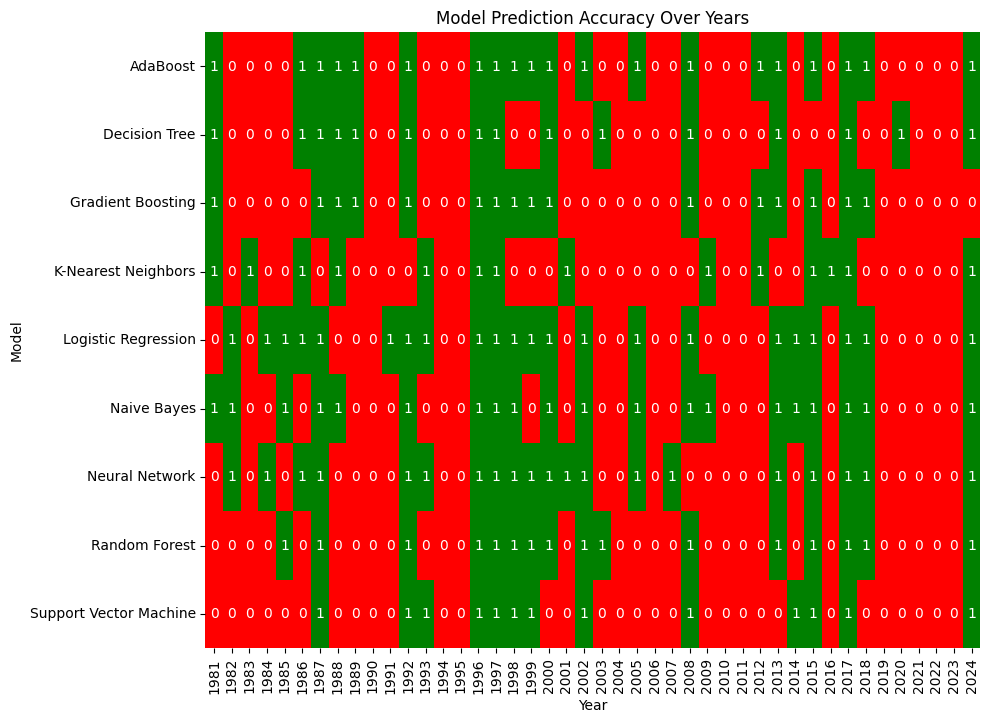

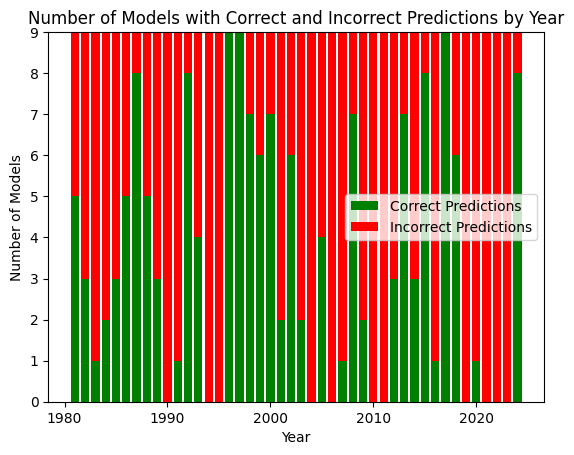

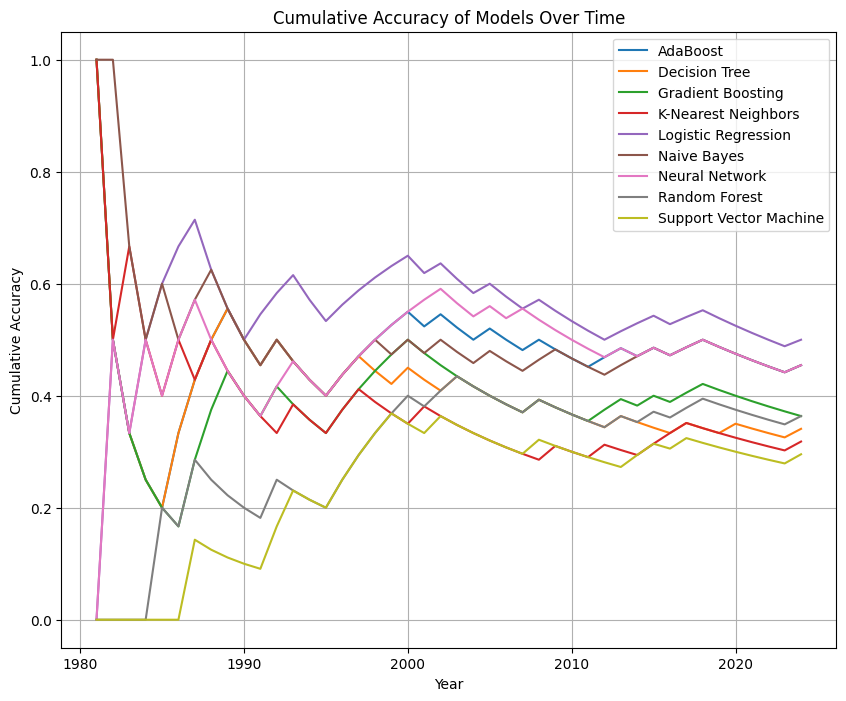

Logistic Regression: 38.708333333333336
Naive Bayes: 38.5625
Neural Network: 38.27083333333333
AdaBoost: 36.625
Random Forest: 36.5625
Gradient Boosting: 33.041666666666664
Support Vector Machine: 31.25
K-Nearest Neighbors: 29.3125
Decision Tree: 22.229166666666664


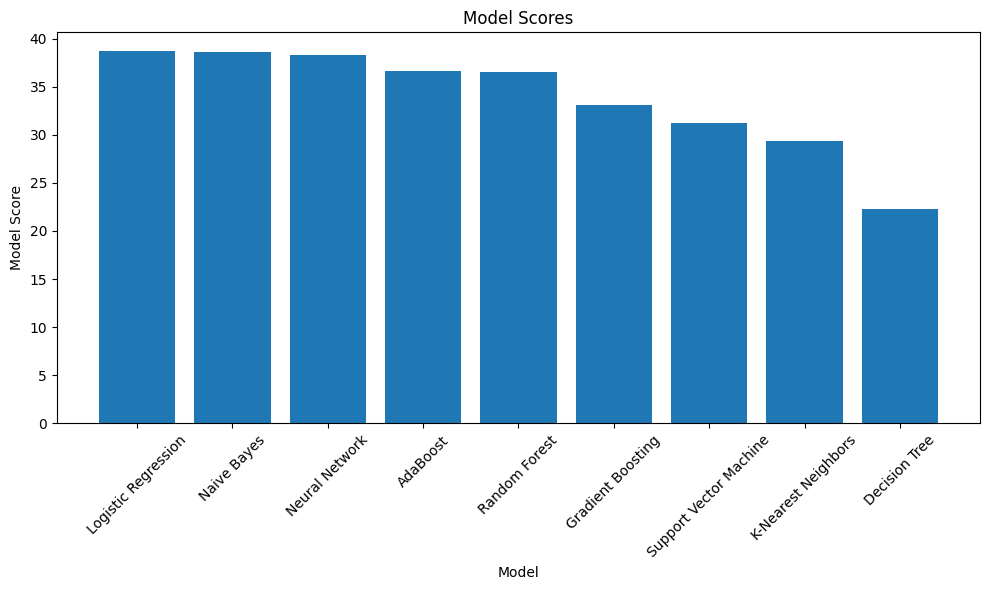

In [116]:
if __name__ == '__main__':
    main()